# Text clustering

In [187]:
# data handling and numerical operations
import pandas as pd
import numpy as np
from collections import defaultdict

# clustering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from time import time

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
sns.set()

## Loading data
A collection of Dutch news articles is used for the analysis.

In [188]:
with open("datasets/dutch_news_articles", "r") as f:
        
    titles = []
    texts = []
    categories = []
    
    temp_dict = {"title": [], "category": [], "text": []}

    for s in f.readlines()[23:25000]:
        
        # get stuff between quotes with regex
        s_between = s[s.find("'") + 1 : s.rfind("'")]
        s_outer = s.split(s_between)

        category = str(s_outer).split(",")[2]
        if len(category) < 15:
            categories.append(category)

            # turn into list, remove additional quotes and exclude date (first item)
            s_list = s_between.split("','")[1:]

            # store
            try:
                if s_list[0] and category and s_list[1]:
                    temp_dict["title"].append(s_list[0])
                    temp_dict["category"].append(category)
                    temp_dict["text"].append(s_list[1])
            except:
                # print(s_list)
                pass


In [189]:
df = pd.DataFrame.from_dict(temp_dict)
df

,title,category,text
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...
...,...,...,...
24956,Hengelose blijft dreigtweets sturen,Binnenland,Een 18-jarige vrouw uit Hengelo die al twee ke...
24957,Deense premier heeft coalitie rond,Buitenland,Aanstaand premier van Denenmarken Helle Thorni...
24958,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er dit en volgend jaar niet...
24959,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er niet in het begrotingste...


In [190]:
# df.to_csv("datasets/dutch_news.csv", index=False)

In [191]:
# balance groups for better predictions
# df = df[~df.category.isin(["Koningshuis", "Economie"])]

In [192]:
# actual category distribution
category_sizes = df.groupby("category")["category"].count()
category_sizes

category
Binnenland      8234
Buitenland     10767
Economie        2208
Koningshuis      165
Politiek        3587
Name: category, dtype: int64

In [193]:
unique_labels = category_sizes.keys()
unique_labels

Index(['Binnenland', 'Buitenland', 'Economie', 'Koningshuis', 'Politiek'], dtype='object', name='category')

In [194]:
true_k = len(unique_labels)

## Preprocessing

### Cleaning

In [195]:
df

,title,category,text
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...
...,...,...,...
24956,Hengelose blijft dreigtweets sturen,Binnenland,Een 18-jarige vrouw uit Hengelo die al twee ke...
24957,Deense premier heeft coalitie rond,Buitenland,Aanstaand premier van Denenmarken Helle Thorni...
24958,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er dit en volgend jaar niet...
24959,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er niet in het begrotingste...


In [196]:
df.text[0]

'De enige kerncentrale van Litouwen is oudjaarsavond om 23.00 uur buiten gebruik gesteld. Dat verliep zonder problemen, aldus de directeur. Litouwen beloofde al in 2004 om de centrale te sluiten in ruil voor toetreding tot de Europese Unie. De EU wilde sluiting omdat de kerncentrale bij de stad Visiginas mogelijk niet veilig was. Nucleaire ramp De centrale is een grotere versie van die bij Tsjernobyl. Die ontplofte in 1986 en veroorzaakte een nucleaire wolk die over een groot deel van Europa trok. Dat was de grootste nucleaire ramp in de geschiedenis. Voor Litouwen betekent de sluiting dat het land een goedkope bron van energie kwijt is. Het wordt nu veel afhankelijker van bijvoorbeeld gas uit Rusland. De kerncentrale leverde bijna driekwart van de Litouwse energiebehoefte.'

### Stopwords
Gather a collection of stopwords which are removed later. More stopwords can be added after inspecting the results.

In [197]:
# get list of dutch stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('dutch'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [198]:
additional_stopwords = ['zullen', 'zeggen', 'moeten', 'gaan', 'volgen', 'volgens', 'komen', 'willen', 'krijgen', 'vinden', 'staan']
additional_stopwords2 = [ "liggen", "blijven", "geven", "twee", "één", "maken"]
additional_stopwords3 = ["we", "weg", "wel", "nederland"]
stopwords_list.update(additional_stopwords)
stopwords_list.update(additional_stopwords2)
stopwords_list.update(additional_stopwords3)

### Lemmatization with spaCy
Bring the words back to their stem using a pre-trained model. In this step, stopwords are also removed. (Note: the word is first converted to lemma form and then it is checked for being a stopword. Depending on the stopwords, this has to be changed.)

In [199]:
# note: make sure library is downloaded -> in terminal: python -m spacy download nl_core_news_sm
import spacy
nlp = spacy.load("nl_core_news_sm")

In [200]:
texts = df.text

In [201]:
texts[0]

'De enige kerncentrale van Litouwen is oudjaarsavond om 23.00 uur buiten gebruik gesteld. Dat verliep zonder problemen, aldus de directeur. Litouwen beloofde al in 2004 om de centrale te sluiten in ruil voor toetreding tot de Europese Unie. De EU wilde sluiting omdat de kerncentrale bij de stad Visiginas mogelijk niet veilig was. Nucleaire ramp De centrale is een grotere versie van die bij Tsjernobyl. Die ontplofte in 1986 en veroorzaakte een nucleaire wolk die over een groot deel van Europa trok. Dat was de grootste nucleaire ramp in de geschiedenis. Voor Litouwen betekent de sluiting dat het land een goedkope bron van energie kwijt is. Het wordt nu veel afhankelijker van bijvoorbeeld gas uit Rusland. De kerncentrale leverde bijna driekwart van de Litouwse energiebehoefte.'

In [202]:
def lemmatizer(texts):
    """
    Bring words back to their root (lemma) using SpaCy Dutch pipeline.
    Note: avoid removing too much, some stopwords might be useful!
    """
    # remove enter (\n) after texts
    texts = [text.strip() for text in texts]

    # create spacy pipeline for nlp process
    docs = nlp.pipe(texts)

    # convert all texts into lists of lemmas and remove stopwords
    all_cleaned_lemmas = []
    for doc in docs:
        text_cleaned_lemmas = [text.lemma_ for text in doc if text.lemma_ not in stopwords_list]
        all_cleaned_lemmas.append(text_cleaned_lemmas)

    return all_cleaned_lemmas


cleaned_texts = lemmatizer(texts)
print(len(cleaned_texts), len(texts))

print(cleaned_texts[0], "\n\n", texts[0])

24961 24961
['enig', 'kerncentrale', 'Litouwen', 'oudjaarsavaan', '23.00', 'uur', 'buiten', 'gebruik', 'stellen', '.', 'verlopen', 'probleem', ',', 'aldus', 'directeur', '.', 'Litouwen', 'beloven', '2004', 'centraal', 'sluiten', 'ruil', 'toetreding', 'Europese', 'Unie', '.', 'EU', 'sluiting', 'kerncentrale', 'stad', 'Visiginas', 'mogelijk', 'veilig', '.', 'nucleair', 'ramp', 'centrale', 'groot', 'versie', 'Tsjernobyl', '.', 'ontploffen', '1986', 'veroorzaken', 'nucleair', 'wolk', 'groot', 'deel', 'Europa', 'trekken', '.', 'groot', 'nucleair', 'ramp', 'geschiedenis', '.', 'Litouwen', 'betekenen', 'sluiting', 'land', 'goedkoop', 'bron', 'energie', 'kwijt', '.', 'afhankelijker', 'bijvoorbeeld', 'gas', 'Rusland', '.', 'kerncentrale', 'leveren', 'bijna', 'driekwart', 'Litouws', 'energiebehoefte', '.'] 

 De enige kerncentrale van Litouwen is oudjaarsavond om 23.00 uur buiten gebruik gesteld. Dat verliep zonder problemen, aldus de directeur. Litouwen beloofde al in 2004 om de centrale te slu

### Lowercase
Convert all words to lowercase such that the model perceives them as the same word.

In [203]:
# convert to lowercase
cleaned_texts_lower = [[x.lower() for x in text] for text in cleaned_texts]

In [204]:
# convert list of words back to string (the cleaned text)
cleaned_texts_str = [" ".join(cleaned_text) for cleaned_text in cleaned_texts_lower]

In [205]:
# check: cleaning is not removing texts
assert(len(cleaned_texts_str) == len(cleaned_texts) == len(df.text))

In [206]:
# add cleaned texts to the dataframe
df["cleaned_text"] = cleaned_texts_str
df.head()

,title,category,text,cleaned_text
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...,enig kerncentrale litouwen oudjaarsavaan 23.00...
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...,spanje ingang vandaag voorzitter eu . zweeds p...
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...,vijf werknemer omstreden amerikaans beveilingi...
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...,oud nieuwfeest museumplein amsterdam tussen 40...
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...,president obama rapport mislukken aanslag vlie...


## Feature extraction
### TF-IDF vectorizing

In [207]:
# perform vectoring on the cleaned texts
texts = df.cleaned_text
texts

0        enig kerncentrale litouwen oudjaarsavaan 23.00...
1        spanje ingang vandaag voorzitter eu . zweeds p...
2        vijf werknemer omstreden amerikaans beveilingi...
3        oud nieuwfeest museumplein amsterdam tussen 40...
4        president obama rapport mislukken aanslag vlie...
                               ...                        
24956    18jarig vrouw hengelo keer eerder aanhouden dr...
24957    aanstaand premier denenmarken helle thorning-s...
24958    griekenland slagen jaar begrotingstekort voldo...
24959    griekenland slagen begrotingstekort binnen jaa...
24960    ozonverlies boven noordpool groot spreken gat ...
Name: cleaned_text, Length: 24961, dtype: object

In [208]:
# create vectorizer and set params
vectorizer = TfidfVectorizer(
    max_df=0.3, # exclude words which occur in more than 30% of the text
    min_df=5, # remove words that occur less than 5 times
    # lowercase=True, # cleaning: converts all inputs to lowercase (already doing that)
    ngram_range=(1,3)
)

# fit vectorizer to data
t0 = time()
X_tfidf = vectorizer.fit_transform(texts)

print(f"vectorization took {time() - t0:.1f} sec for {len(texts)} texts\n")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization took 20.5 sec for 24961 texts

n_samples: 24961, n_features: 77767


In [209]:
# note: 1 to 3-grams
vectorizer.get_feature_names()[10:20]

['00 uur',
 '00 uur beginnen',
 '00 uur dicht',
 '00 uur duren',
 '00 uur live',
 '00 uur lokaal',
 '00 uur nacht',
 '00 uur nederland',
 '00 uur nederlands',
 '00 uur nos']

In [210]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape) :.3f}% of the entries in X_tfidf matrix are non-zero")

0.001% of the entries in X_tfidf matrix are non-zero


In [211]:
X_tfidf

<24961x77767 sparse matrix of type '<class 'numpy.float64'>'
	with 2308754 stored elements in Compressed Sparse Row format>

## Clustering

### Note
KMeans is optimizing a non-convex objective function, therefore the clustering is not guaranteed to be optimal for random initiations. This can be seen below. Additionally, sparse high-dimensional data can lead to initialization of centroids on isolated data points. These data points stay their own centroids over iterations. Avoid this problem by increasing `n_init` -> increases number of runs with random initiation and chooses the best one

In [212]:
# random seeds determine outcome severely
for seed in range(5):

    # create and fit model
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=5,
        random_state=seed,
    ).fit(X_tfidf)

    # insights
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
    print()
print("True number of documents in each category according to the class labels: "
    f"{category_sizes}")

Number of elements assigned to each cluster: [13834   658  2158  3594  4717]

Number of elements assigned to each cluster: [14327  3373  2105  4490   666]

Number of elements assigned to each cluster: [ 1978   661  4178  7343 10801]

Number of elements assigned to each cluster: [  659  4242  2117 13401  4542]

Number of elements assigned to each cluster: [ 4219 13944   658  2097  4043]

True number of documents in each category according to the class labels: category
Binnenland      8234
Buitenland     10767
Economie        2208
Koningshuis      165
Politiek        3587
Name: category, dtype: int64


In [213]:
unique_labels

Index(['Binnenland', 'Buitenland', 'Economie', 'Koningshuis', 'Politiek'], dtype='object', name='category')

### Elbow method for optimal k

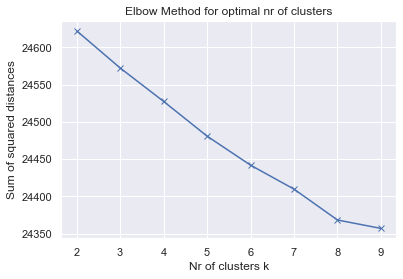

In [214]:
# elbow method for determining optimal cluster number
K = range(2,10)
sum_squared_errors = []

# vary the number of clusters
for k in K:

    # create and fit model
    kmeans = KMeans(
        n_clusters=k,
        max_iter=1000,
        n_init=15,
        random_state=seed,
    ).fit(X_tfidf)
    sum_squared_errors.append(kmeans.inertia_)

# plot the squared error per nr of clusters 
plt.plot(K, sum_squared_errors, 'bx-')
plt.xlabel('Nr of clusters k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for optimal nr of clusters')
plt.show()


### Model evaluation

In [215]:
# evaluation metrics from sklearn
actual_labels = df.category

def fit_and_evaluate(km, X, name=None, n_runs=5):
    evaluations = []
    evaluations_std = []
    train_times = []
    scores = defaultdict(list)

    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(actual_labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(actual_labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(actual_labels, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(actual_labels, km.labels_))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X, km.labels_, sample_size=2000))
    
    train_times = np.asarray(train_times)
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [216]:
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
cluster_ids, cluster_sizes

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([9951, 2651, 3392, 1836,  651, 2010,  513, 3009,  948], dtype=int64))

In [217]:
# map clusters to labels
# note: dict(zip()) not working -> workaround
def convert(tuple, dictionary):
    for a, b in tuple:
        dictionary[a] = b
    return dictionary
     
dictionary = {}
mapping = list(zip(cluster_ids, unique_labels))
mapping = convert(mapping, dictionary)
mapping

{0: 'Binnenland',
 1: 'Buitenland',
 2: 'Economie',
 3: 'Koningshuis',
 4: 'Politiek'}

Meaning evaluation scores: 
* all have a maximum value of 1.0 for perfect clustering
* adjusted rand-index -> 0 indicates random labeling

In [218]:
# actual model (we know how many clusters we need)
kmeans = KMeans(
        n_clusters=true_k,
        max_iter=1000,
        n_init=15,
        random_state=42,
    )

In [219]:
fit_and_evaluate(kmeans, X_tfidf, name="KMeans tf-idf vectors")

clustering done in 140.56 ± 4.76 s 
Homogeneity: 0.271 ± 0.029
Completeness: 0.281 ± 0.025
V-measure: 0.276 ± 0.027
Adjusted Rand-Index: 0.177 ± 0.046
Silhouette Coefficient: 0.004 ± 0.000


In [220]:
clusters = kmeans.labels_

# apply mapping to store predicted labels in df
df['cluster'] = clusters
df['cluster_label'] = df['cluster'].map(mapping)

In [221]:
# Compute Silhoutte Score
ss = metrics.silhouette_score(X_tfidf.toarray(), kmeans.labels_ , metric='euclidean')
ss

0.0032910206164201944

In [222]:
from sklearn.metrics.cluster import v_measure_score
v_measure_score(actual_labels, kmeans.labels_)

0.23067438973593732

## Dimensionality reduction and visualization

In [223]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# pass X to the PCA and store the reduced vectors
pca_vecs = pca.fit_transform(X_tfidf.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [224]:
# assign clusters and PCA vectors to dataframe for plotting
df['x0'] = x0
df['x1'] = x1

In [225]:
df.head()

,title,category,text,cleaned_text,cluster,cluster_label,x0,x1
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...,enig kerncentrale litouwen oudjaarsavaan 23.00...,0,Binnenland,-0.006899,0.030289
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...,spanje ingang vandaag voorzitter eu . zweeds p...,0,Binnenland,0.029260,0.041446
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...,vijf werknemer omstreden amerikaans beveilingi...,3,Koningshuis,-0.042256,-0.008737
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...,oud nieuwfeest museumplein amsterdam tussen 40...,0,Binnenland,-0.024943,0.031800
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...,president obama rapport mislukken aanslag vlie...,0,Binnenland,-0.019898,-0.027362


In [226]:
def top_words_per_cluster(model, vect):
    """
    Print the most occurring words per cluster.
    """
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    words = vect.get_feature_names()
    for i, cluster in enumerate(order_centroids):
        print(f"Cluster {i}:", end="\n")
        for ind in order_centroids[i, :10]:
            print(words[ind])
        print()

In [227]:
top_words_per_cluster(kmeans, vectorizer)

Cluster 0:
mens
president
groot
land
nieuw
nederland
ander
week
goed
amerikaans

Cluster 1:
pvv
cda
wilders
vvd
kabinet
rutte
partij
pvda
kamer
d66

Cluster 2:
euro
procent
bank
miljard
miljoen
miljoen euro
miljard euro
griekenland
financieel
geld

Cluster 3:
politie
man
vrouw
brand
auto
mens
raken
verdenken
gewond
aanhouden

Cluster 4:
kadhafi
libie
libisch
tripoli
opstandeling
navo
stad
opstandelingen
kolonel
benghazi



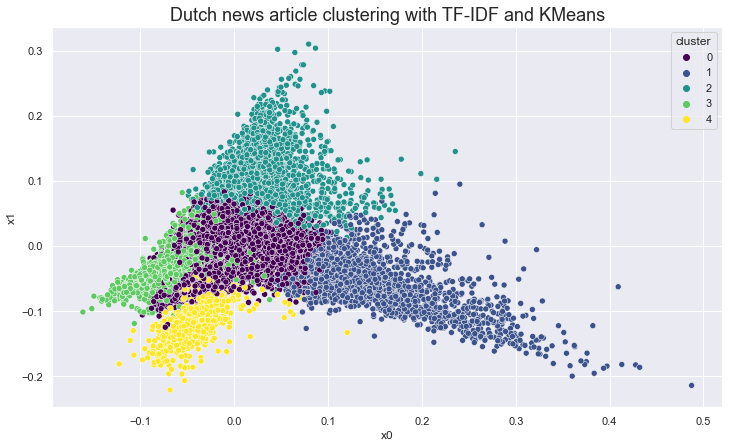

In [228]:
# cluster plotting
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.title("Dutch news article clustering with TF-IDF and KMeans", fontdict={"fontsize": 18})
plt.savefig("results/clustered_articles.png", dpi=300)
plt.show()

## Wordcloud

In [229]:
def word_cloud(text, cluster):

    # Create WordCloud 
    word_cloud = WordCloud(width = 800, height = 500, 
                           background_color ='white', 
                           stopwords = stopwords_list, 
                           min_font_size = 14).generate(text) 

    # Set wordcloud figure size
    plt.figure(figsize = (8, 6)) 
    
    # Set title for word cloud
    plt.title(f"Cluster {cluster}")
    
    # Show image
    plt.imshow(word_cloud) 

    # Remove Axis
    plt.axis("off")  

    # show plot
    plt.show()

In [230]:
df

,title,category,text,cleaned_text,cluster,cluster_label,x0,x1
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...,enig kerncentrale litouwen oudjaarsavaan 23.00...,0,Binnenland,-0.006899,0.030289
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...,spanje ingang vandaag voorzitter eu . zweeds p...,0,Binnenland,0.029260,0.041446
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...,vijf werknemer omstreden amerikaans beveilingi...,3,Koningshuis,-0.042256,-0.008737
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...,oud nieuwfeest museumplein amsterdam tussen 40...,0,Binnenland,-0.024943,0.031800
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...,president obama rapport mislukken aanslag vlie...,0,Binnenland,-0.019898,-0.027362
...,...,...,...,...,...,...,...,...
24956,Hengelose blijft dreigtweets sturen,Binnenland,Een 18-jarige vrouw uit Hengelo die al twee ke...,18jarig vrouw hengelo keer eerder aanhouden dr...,3,Koningshuis,-0.047712,-0.025606
24957,Deense premier heeft coalitie rond,Buitenland,Aanstaand premier van Denenmarken Helle Thorni...,aanstaand premier denenmarken helle thorning-s...,2,Economie,0.045045,0.035941
24958,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er dit en volgend jaar niet...,griekenland slagen jaar begrotingstekort voldo...,2,Economie,0.044841,0.133483
24959,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er niet in het begrotingste...,griekenland slagen begrotingstekort binnen jaa...,2,Economie,0.055876,0.134868


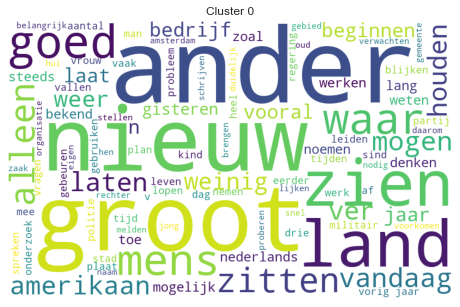

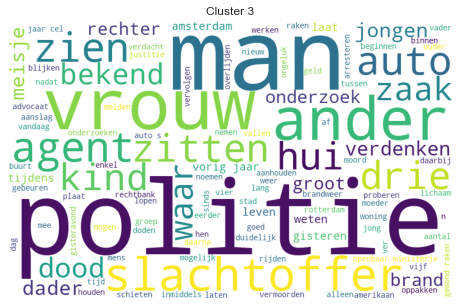

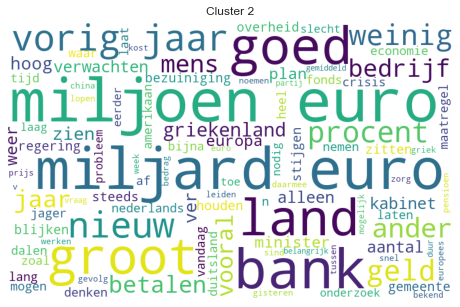

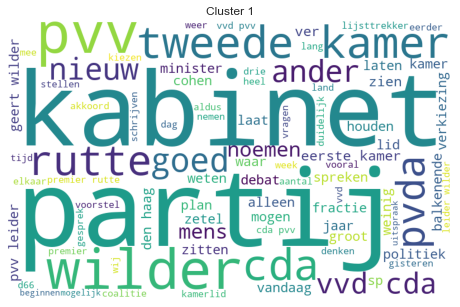

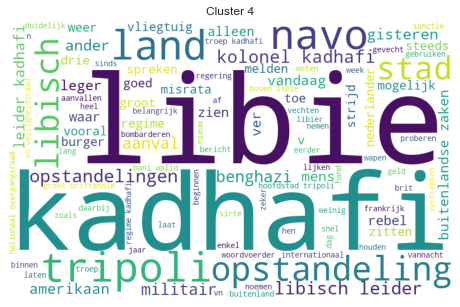

In [231]:
# plotting
for i in df.cluster.unique():
    texts_same_cluster = "".join(df[df.cluster == i].cleaned_text.tolist())
    word_cloud(texts_same_cluster, i)

## Latent Dirichlet Allocation (LDA)
Topic modelling

In [232]:
n_features = 1000
n_components = true_k
n_top_words = 20

In [233]:
tf_vectorizer = CountVectorizer(
    max_df=0.5, 
    min_df=2, 
    max_features=n_features, 
    stop_words="english"
)
X_tf = tf_vectorizer.fit_transform(df.cleaned_text)

In [234]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
).fit(X_tf)

In [235]:
def plot_top_words(model, feature_names, n_top_words, title):
    """
    Sklearn function for plotting.
    """
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

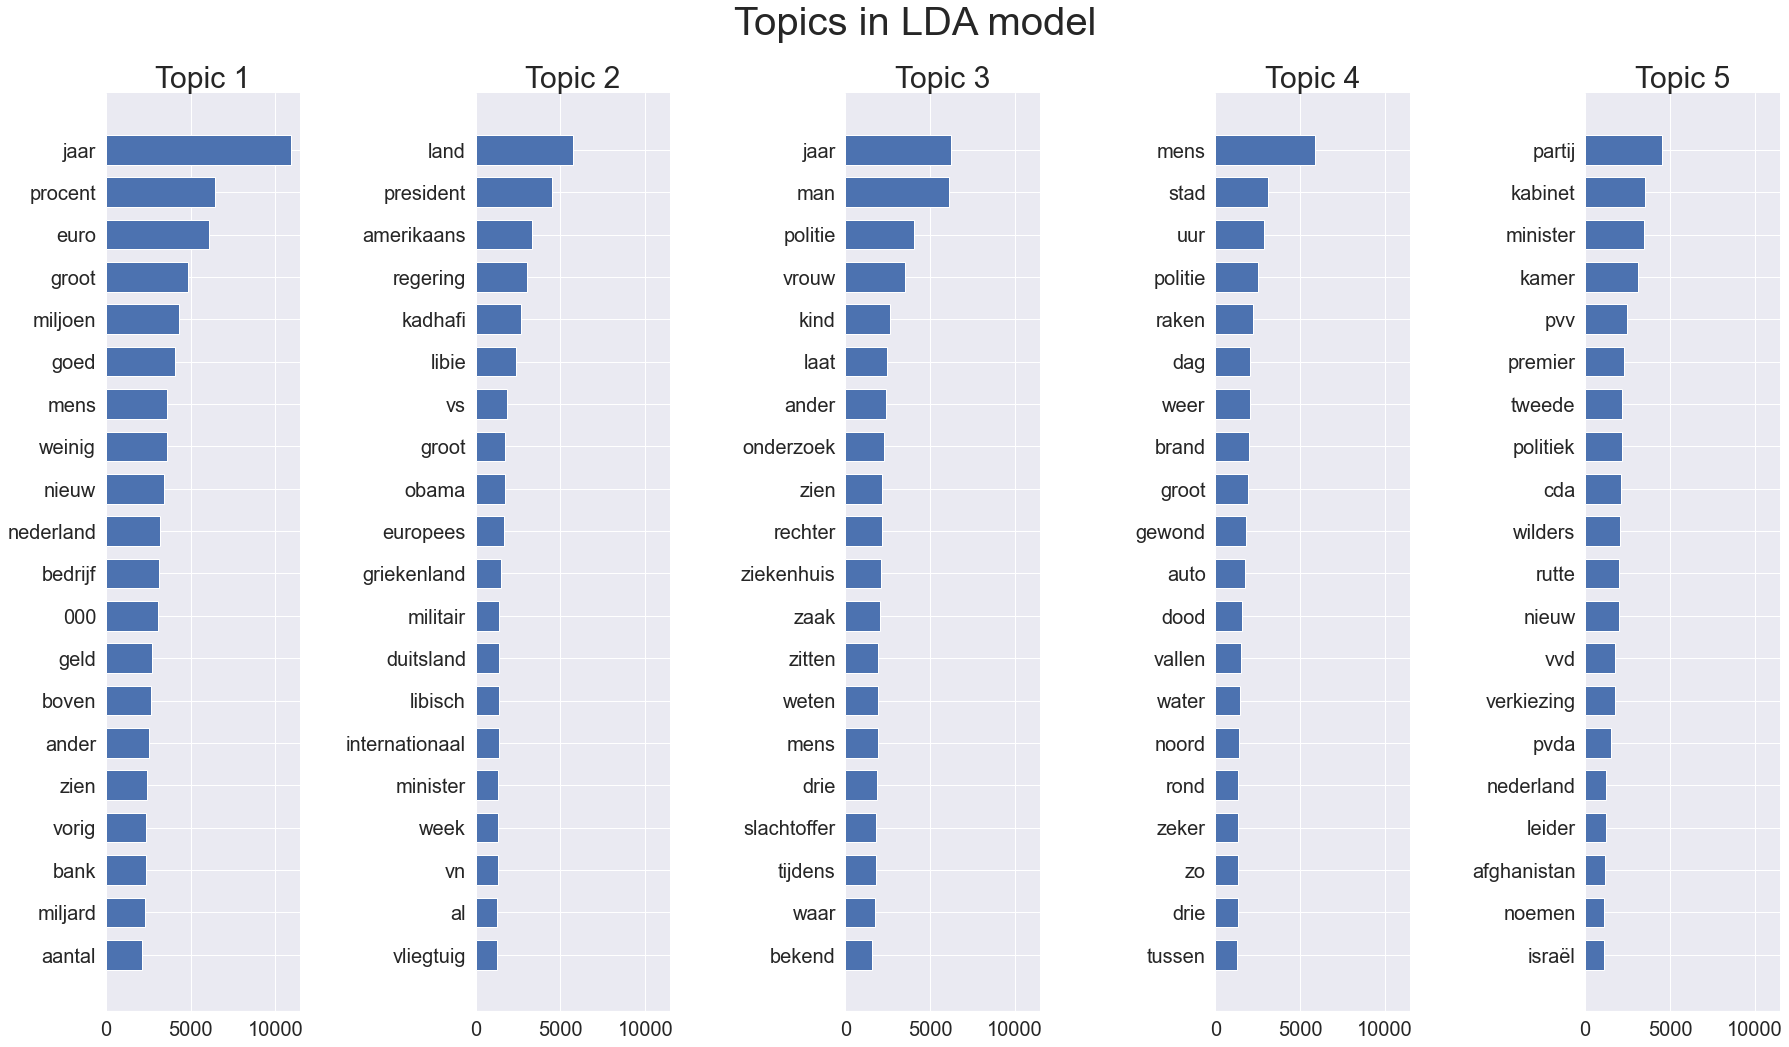

In [236]:
# plotting
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [237]:
# word embeddings
# from transformers import RobertaTokenizer, RobertaForSequenceClassification
# tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
# model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base")

## Latent Semantic Analysis (LSA)

The dimension of the vectorized space can be reduced to make kmeans more stable and allow for using `n_init=1` as a parameter. Using the reduced form of the data makes clustering much faster.

This can be done using `TruncatedSVD`, truncated singular value decomposition (SVD). Whereas PCA centers the data before computing, this estimator does not, making it more efficient in working with sparce matrices.

Note that LSA is not a model, it is the process of using SVD on the vectorized TF-IDF matrix.

In [238]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer


In [239]:
# add normalization step after truncation to improve kmeans result, because SVD results are not normalized
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))

# reduce TF-IDF matrix
X_lsa = lsa.fit_transform(X_tfidf)

# explained variance
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"explained_variance: {explained_variance * 100:.2f}%")

explained_variance: 10.15%


In [240]:
# run model again
kmeans_lsa = KMeans(
        n_clusters=true_k,
        max_iter=1000,
        n_init=15,
        random_state=42
    )

In [241]:
# faster and even improved the scores
fit_and_evaluate(kmeans_lsa, X_lsa, name="KMeans LSA vectors")

clustering done in 1.44 ± 0.09 s 
Homogeneity: 0.321 ± 0.000
Completeness: 0.265 ± 0.000
V-measure: 0.290 ± 0.000
Adjusted Rand-Index: 0.246 ± 0.000
Silhouette Coefficient: 0.039 ± 0.001
